![CleanShot 2025-01-12 at 10.26.44@2x.png](<attachment:CleanShot 2025-01-12 at 10.26.44@2x.png>)

![CleanShot 2025-01-12 at 10.41.42@2x.png](<attachment:CleanShot 2025-01-12 at 10.41.42@2x.png>)
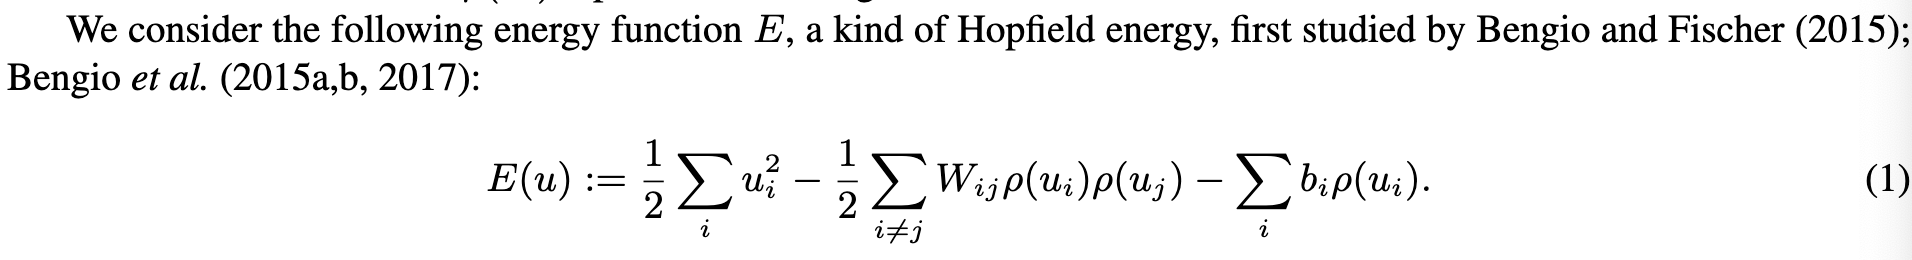
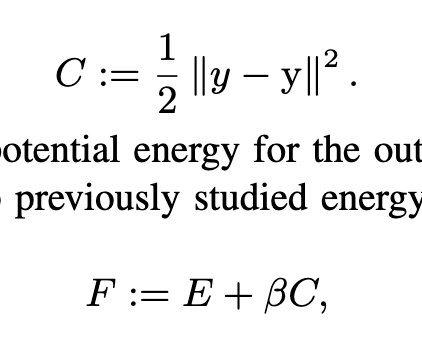

In [301]:
import jax
import jax.numpy as jnp
import equinox as eqx


class MLP(eqx.Module):
    layer: eqx.nn.Linear
    def __init__(self, key: jax.Array):
        self.layer = eqx.nn.Linear(2, 2, use_bias=False, key=key)

    def __call__(self, input: jax.Array):
        return self.layer(input)
    
    def energy(self, x, y, target, beta = 0):
        total = 0.5 * (jnp.linalg.norm(y) ** 2 + jnp.linalg.norm(x) ** 2)
        total -= 0.5 * jnp.dot(jax.nn.hard_sigmoid(y), jnp.dot(self.layer.weight, jax.nn.hard_sigmoid(x)))
        # total -= jnp.dot(self.layer.bias, x)
        # print(f"Beta: {beta} + {beta * 0.5 * jnp.linalg.norm(y - target) ** 2}")
        total += beta * 0.5 * jnp.linalg.norm(y - target) ** 2
        # energy -= jnp.dot(self.layer.bias, y)

        return total


![CleanShot 2025-01-12 at 12.31.13@2x.png](<attachment:CleanShot 2025-01-12 at 12.31.13@2x.png>)
![CleanShot 2025-01-12 at 12.31.41@2x.png](<attachment:CleanShot 2025-01-12 at 12.31.41@2x.png>)
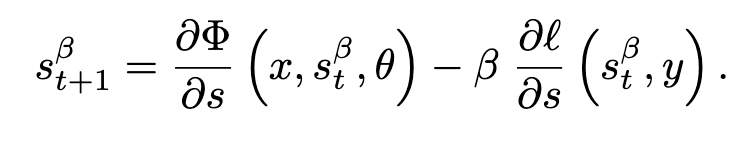
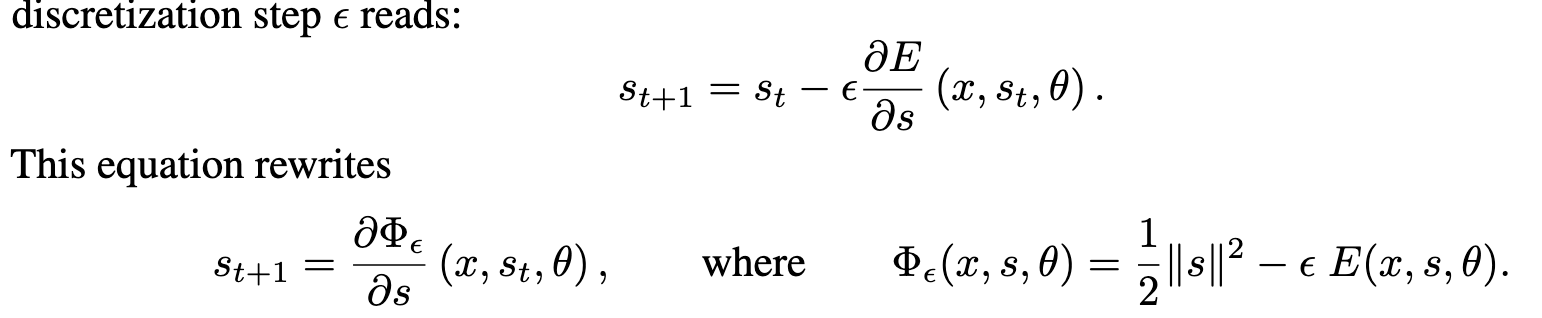

[ 0. -1.]


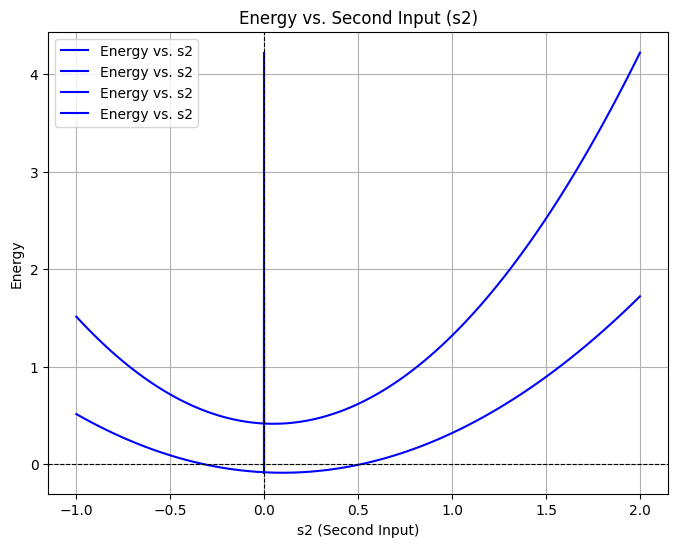

In [308]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx

model = MLP(key= jax.random.key(1))
model = eqx.tree_at(lambda q: q.layer.weight, model, jnp.ones((2,2)))

s1 = jnp.array([1.0, 0.0])  # First input
x = jnp.array([1.0, 0.0])   # Fixed input

# Generate data points
s2_values = jnp.column_stack([ jnp.zeros((100, 1)), jnp.expand_dims(jnp.linspace(-1, 2, 100), -1)])  # Varying the second input
print(s2_values[0])
energy_values = jnp.array([model.energy(s1, s2, x) for s2 in s2_values])
energy_values_with_beta = jnp.array([model.energy(s1, s2, x, 1) for s2 in s2_values])
# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(s2_values, energy_values, label="Energy vs. s2", color="blue")
plt.plot(s2_values, energy_values_with_beta, label="Energy vs. s2", color="blue")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)  # Reference line
plt.axvline(0, color="black", linestyle="--", linewidth=0.8)  # Reference line
plt.title("Energy vs. Second Input (s2)")
plt.xlabel("s2 (Second Input)")
plt.ylabel("Energy")
plt.legend()
plt.grid()
plt.show()

In [303]:
model = MLP(key= jax.random.key(1))
model = eqx.tree_at(lambda q: q.layer.weight, model, jnp.array([[0, 1], [0,0]]))

beta = 0.0000001

def first_phase(x: jax.Array, y: jax.Array, target: jax.Array):
    for i in range(0, 5):
        # X is clamped so we don't move it. Only y can vary.
        y = jnp.clip(y - 0.5 * jax.grad(model.energy, argnums=1)(x, y, target, 0), 0.0001, 0.9999)
        print(f"First phase #{i}: Y = {y}, X = {x}")
    return x, y, target

def second_phase(x: jax.Array, y: jax.Array, target: jax.Array):
    for i in range(0, 5):
        y = jnp.clip(y - 0.5 * jax.grad(model.energy, argnums=1)(x, y, target, beta), 0.0001, 0.9999)
        print(f"Second phase #{i}: Y = {y}, X = {x}")
    return x, y, target

x = jnp.array([1, 0])
target = jnp.array([0, 1])
key = jax.random.key(0)
for i in range(0, 100):
    key, k = jax.random.split(key)
    y = jax.random.uniform(key=k, shape=(2,))
    # y = jnp.array([1.0])
    # print(y)
    x, y, target = first_phase(x, y, target)
    w_0 = jnp.outer(jax.nn.hard_sigmoid(x), jax.nn.hard_sigmoid(y).T)

    x, y, target = second_phase(x, y, target)
    w_beta = jnp.outer(jax.nn.hard_sigmoid(x), jax.nn.hard_sigmoid(y).T)

    # print(f"W_0: {w_0}")
    # print(f"W_beta: {w_beta}")

    update = model.layer.weight - (1/beta)*(w_beta - w_0)
    print(model.layer.weight)
    model = eqx.tree_at(lambda q: q.layer.weight, model, update)

    print(f"Current error rate: {0.5 *jnp.linalg.norm(y - target) ** 2}, Y: {y}, Target: {target}")

First phase #0: Y = [0.30910873 0.1495861 ], X = [1 0]
First phase #1: Y = [0.1753877  0.07479305], X = [1 0]
First phase #2: Y = [0.10852718 0.03739652], X = [1 0]
First phase #3: Y = [0.07509693 0.01869826], X = [1 0]
First phase #4: Y = [0.0583818  0.00934913], X = [1 0]
Second phase #0: Y = [0.05002423 0.00467461], X = [1 0]
Second phase #1: Y = [0.04584545 0.00233736], X = [1 0]
Second phase #2: Y = [0.04375605 0.00116873], X = [1 0]
Second phase #3: Y = [0.04271136 0.00058441], X = [1 0]
Second phase #4: Y = [0.04218901 0.00029226], X = [1 0]
[[0 1]
 [0 0]]
Current error rate: 0.5005977749824524, Y: [0.04218901 0.00029226], Target: [0 1]
First phase #0: Y = [0.9999 0.9999], X = [1 0]
First phase #1: Y = [0.9999 0.9999], X = [1 0]
First phase #2: Y = [0.9999 0.9999], X = [1 0]
First phase #3: Y = [0.9999 0.9999], X = [1 0]
First phase #4: Y = [0.9999 0.9999], X = [1 0]
Second phase #0: Y = [0.9999 0.9999], X = [1 0]
Second phase #1: Y = [0.9999 0.9999], X = [1 0]
Second phase #2: 

KeyboardInterrupt: 